In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (15,8)

import pandas as pd
import os
import numpy as np
from scipy.optimize import curve_fit

# Utility functions for stream-lining analysis
from utils import *

## Part 1: Calculating growth rates

In [3]:
df = load_jhu_df()
df.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,date,Latitude,Longitude
0,Hubei,Mainland China,1/24/20 17:00,549.0,24.0,31.0,01-24-2020,NaN,NaN
1,Guangdong,Mainland China,1/24/20 17:00,53.0,NaN,2.0,01-24-2020,NaN,NaN
2,Zhejiang,Mainland China,1/24/20 17:00,43.0,NaN,1.0,01-24-2020,NaN,NaN
3,Beijing,Mainland China,1/24/20 17:00,36.0,NaN,1.0,01-24-2020,NaN,NaN
4,Chongqing,Mainland China,1/24/20 17:00,27.0,NaN,NaN,01-24-2020,NaN,NaN


Text(0, 0.5, 'Global deaths')

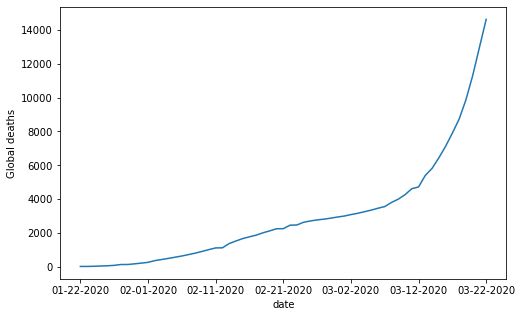

In [4]:
plt.figure(figsize=(8,5))
global_df = df.groupby('date').sum()
global_df['Deaths'].plot(x="date")
plt.ylabel("Global deaths")

### Example: exponential growth in the U.S.

We consider the growth rate of convirmed infections, starting after the 100th case in a Country/Region to avoid poor statistics of small numbers.

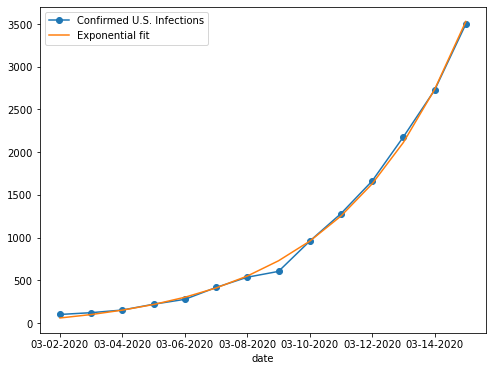

In [5]:
rdf = df.groupby(["Country/Region", "date"]).sum()
rdf_mean = df.groupby(["Country/Region"]).mean()

y, date = growth_period(rdf, 'US')
x = np.arange(0, len(y))

popt, pcov = curve_fit(func, x, y)
yfit = func(x, *popt)

plt.figure(figsize=(8,6))
y.plot(marker='o', label="Confirmed U.S. Infections")
plt.plot(x, yfit, label="Exponential fit")
plt.legend()

In [6]:
all_regions = df['Country/Region'].unique()

growth_rates = []
regions = []
lats = []
lons = []
start_dates = []
end_dates = []

for region in all_regions:
    y, date = growth_period(rdf, region)
    if y is None:
        print(f"Skip {region} where N < 7")
        continue
    elif len(y) < 7:
        print(f"Skip {region} where N < 7")
        continue

    x = np.arange(0, len(y))
    
    try:
        popt, pcov = curve_fit(func, x, y, p0=[100, 0.2, -50])
    except:
        print(f"Could not fit for {region}.")
    
    growth_rates.append(popt[1])
    regions.append(region)
    lats.append(rdf_mean.loc[region]['Latitude'])
    lons.append(rdf_mean.loc[region]['Longitude'])
    start_dates.append(date[0])
    end_dates.append(date[1])
    
    print(f"Computed growth rate {popt[1]} for {region}.")
    
gdf = pd.DataFrame({
    'Country/Region': regions,
    'Growth Rate':growth_rates,
    'Latitude':lats,
    'Longitude':lons,
    'Start day':pd.to_datetime(start_dates),
    'End day':pd.to_datetime(end_dates)
})

Computed growth rate 0.19253976414051777 for Mainland China.
Skip Taiwan where N < 7
Computed growth rate 0.11158800774499482 for Hong Kong.
Skip Macau where N < 7
Computed growth rate 0.248851993063108 for US.
Computed growth rate 0.045556014171384523 for Japan.
Computed growth rate 0.3694999849516071 for Thailand.
Computed growth rate 0.13417084916427208 for South Korea.
Computed growth rate 0.11290455984108291 for Singapore.
Skip Vietnam where N < 7
Computed growth rate 0.228531925913284 for France.
Could not fit for Others.
Computed growth rate 0.228531925913284 for Others.
Computed growth rate 0.10805252177607151 for Malaysia.
Computed growth rate 0.1913202083036326 for Italy.
Computed growth rate 0.12668994496852196 for Iran.
Computed growth rate 0.29991080755971783 for Germany.
Skip UK where N < 7
Skip United Arab Emirates where N < 7
Computed growth rate 0.1948732766899728 for Canada.
Computed growth rate 0.2187546912193049 for Australia.
Computed growth rate 0.3271649214464386

In [7]:
gdf

,Country/Region,Growth Rate,Latitude,Longitude,Start day,End day
0,Mainland China,0.192540,33.453369,111.512734,2020-01-22,2020-02-05
1,Hong Kong,0.111588,22.300000,114.200000,2020-03-02,2020-03-09
2,US,0.248852,38.374732,-90.262391,2020-03-02,2020-03-16
3,Japan,0.045556,36.093091,138.114955,2020-02-21,2020-03-06
4,Thailand,0.369500,15.514091,100.995568,2020-03-15,2020-03-22
5,South Korea,0.134171,36.000000,128.000000,2020-02-20,2020-03-05
6,Singapore,0.112905,1.314573,103.827164,2020-02-29,2020-03-14
7,France,0.228532,12.401230,-21.262191,2020-02-29,2020-03-14
8,Others,0.228532,35.443700,139.638000,2020-02-10,2020-02-24
9,Malaysia,0.108053,3.277500,107.716273,2020-03-09,2020-03-22


### Part 2: Calculating specific humidity

In [8]:
ds = xr.open_dataset("../data/thermodynamic_variables_2020.nc", chunks={'time':50})
ds['q2m'] = sat_specific_humidity(ds['d2m'], ds['sp'])
ds = ds.resample(time='1D').mean().compute()
ds.to_netcdf("../data/output/daily_spec_humidity_2020.nc")

In [25]:
q2m_li = []

for region in gdf['Country/Region']:
    tmp = gdf[gdf['Country/Region'] == region]
    q2m_li.append((
        ds['q2m']
        .sel(latitude=tmp['Latitude'], longitude=tmp['Longitude'], method='nearest')
        .isel(time = (
        (ds['time'] >= tmp['Start day'].values) &
        (ds['time'] < tmp['End day'].values)
        ))
    ).mean().values)
    
qdf = pd.DataFrame({'Country/Region':gdf['Country/Region'], 'Specific Humidity':q2m_li})
gqdf = pd.merge(gdf, qdf)
gqdf.to_csv("../data/output/humidity_and_growth_rates.csv")

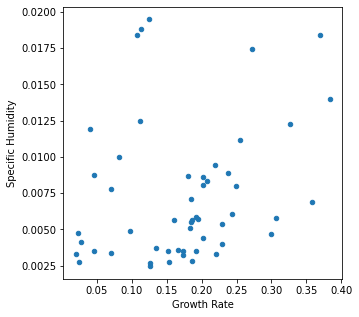

In [26]:
gqdf.plot(x="Growth Rate", y="Specific Humidity", kind='scatter', figsize=(5,5))
plt.savefig("../figures/humidity_and_growth_rates.png", dpi=150, bbox_inches='tight')